# Computes the UT Austin grade distribution data through the 2010s to the early 2020s

## Created by: [Ian Chen](https://github.com/IanC04)

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline

## Data Collection
The data was collected from the [UT Austin Analytics](https://iq-analytics.austin.utexas.edu/views/Gradedistributiondashboard/Externaldashboard-Crosstab?%3Aembed=y) website, which 
provides grade distribution data for each semester.
The data was collected from the Fall 2010 semester to the Spring 2023 semester.
The data was then stored in a CSV file for easy access and manipulation.

In [150]:
# Read in the data
import os
from pathlib import Path

# Order of grades
ordering = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'Other']
mapping = {grade: i for i, grade in enumerate(ordering)}

data = dict()
for f in os.listdir('Grades'):
    year = Path(f).stem
    df = pd.read_csv(f'Grades/{f}', skipinitialspace=True)
    df['Year'] = year
    data[year] = df
del f, year, df

data = pd.concat(data.values(), ignore_index=True)

## Data Cleaning
Look for anomalies and +/- differences

In [151]:
# Grab relevant columns
by_year = data.groupby(['Year', 'Letter Grade'])['Count of letter grade'].sum()

# Grab majors that I want to know
want_to_know_majors = ['Business Administration', 'Chemical Engineering', 'Civil Engineering',
                       'Electrical Engineering', 'Mechanical Engineering', 'Biology', 'Chemistry',
                       'Computer Science', 'Mathematics', 'Physics', 'Communication',
                       'Aerospace Engineering', 'Statistics And Data Sciences',
                       'Environmental Engineering', 'Electrical And Computer Engineering']
majors = data[data['Department/Program'].isin(want_to_know_majors)]
by_dept = majors.groupby(['Department/Program', 'Letter Grade'])['Count of letter grade'].sum()

# Normalize data
Convert sums to proportions

In [152]:
by_year_prop = by_year.groupby('Year').apply(lambda x: x / x.sum())
by_year_prop.reset_index(level=1, drop=True, inplace=True)
by_dept_prop = by_dept.groupby('Department/Program').apply(lambda x: x / x.sum())
by_dept_prop.reset_index(level=1, drop=True, inplace=True)

## Data Analysis
Use pictures to visualize the grade distribution over time

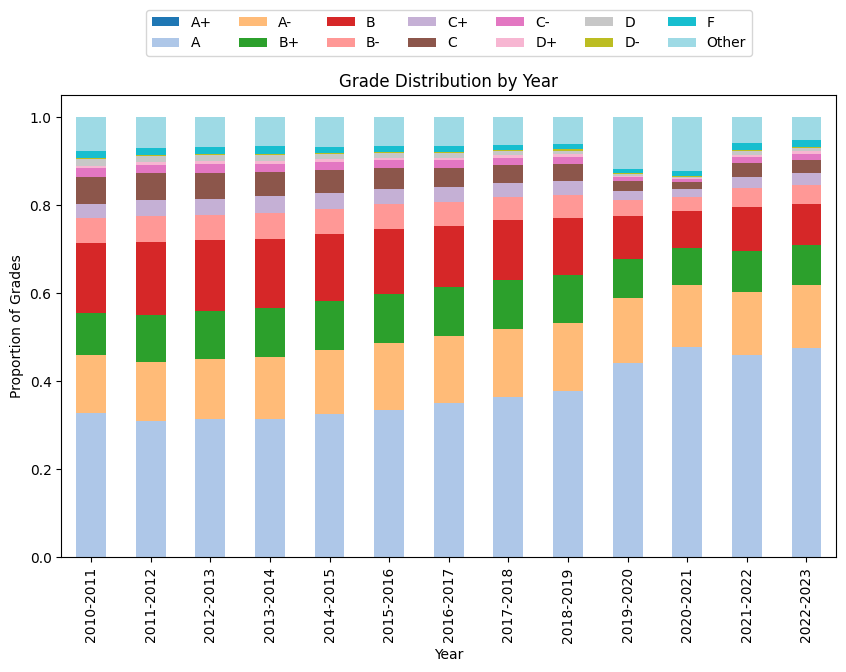

In [153]:
by_year_prop.unstack()[ordering].plot(kind='bar', stacked=True, figsize=(10, 6),
                                      colormap='tab20', title='Grade Distribution by Year')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=7)
plt.ylabel('Proportion of Grades')
plt.xlabel('Year')
plt.title('Grade Distribution by Year')
plt.savefig('Visualizations/grades_by_year.png', bbox_inches='tight')
plt.show()

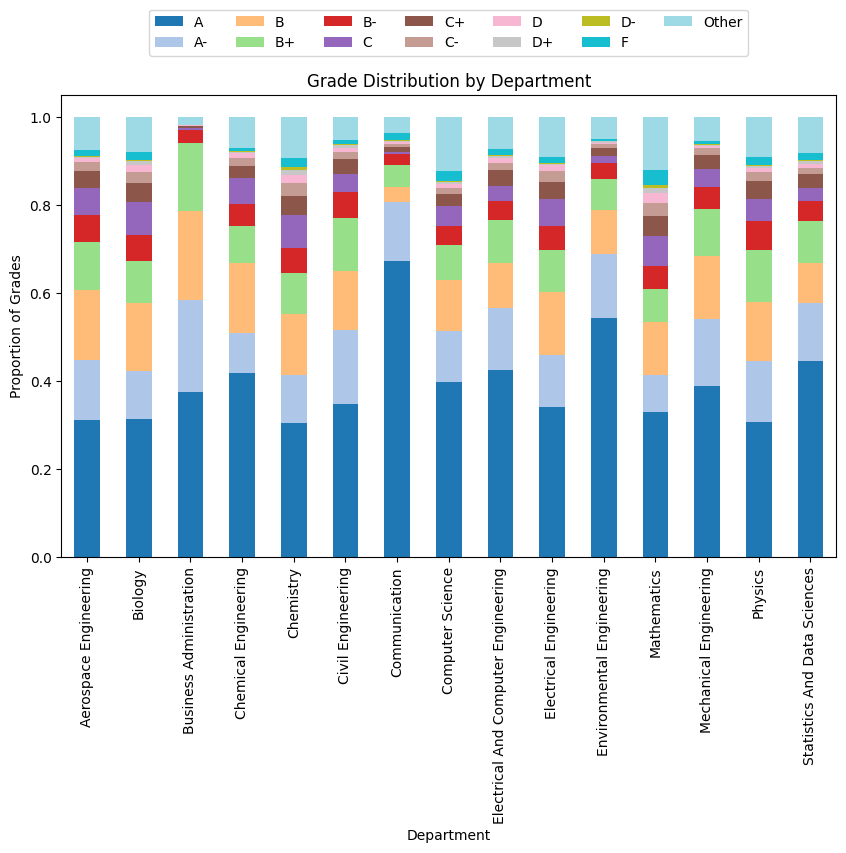

In [154]:
by_dept_prop.unstack().plot(kind='bar', stacked=True, figsize=(10, 6),
                            colormap='tab20', title='Grade Distribution by Department')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=7)
plt.ylabel('Proportion of Grades')
plt.xlabel('Department')
plt.title('Grade Distribution by Department')
plt.savefig('Visualizations/grades_by_dept.png', bbox_inches='tight')
plt.show()

## Data Visualization
Now, we can visualize the grade distribution over time using a GIF.

MovieWriter ffmpeg unavailable; using Pillow instead.


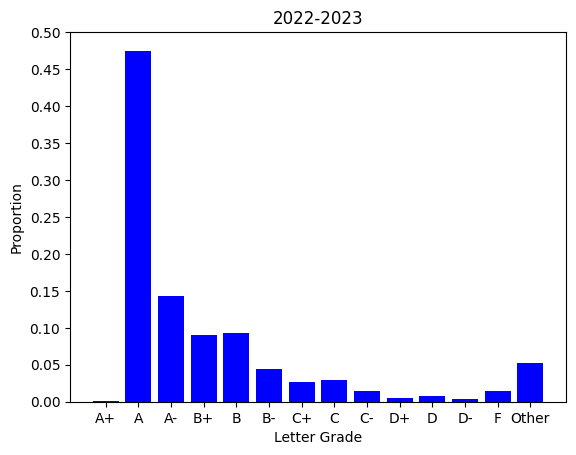

In [155]:
dataframes = by_year_prop.copy().reset_index()
max = dataframes['Count of letter grade'].max()
max = round(max + 0.05, ndigits=1)


# Function to update the plot for each frame
def update(frame):
    ax.cla()
    ax.set_ylim(0, max)
    # Avoid no top tick mark so add 0.01
    ax.set_yticks(np.arange(0, max + 0.01, 0.05))
    filt_year = dataframes[dataframes['Year'] == frame]
    sorted_filt = filt_year.iloc[filt_year['Letter Grade'].map(mapping).argsort()]
    plt.bar(sorted_filt['Letter Grade'], sorted_filt['Count of letter grade'], color='blue')
    plt.title(f'{frame}')
    plt.xlabel('Letter Grade')
    plt.ylabel('Proportion')


# Create the figure and axis
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, update, frames=dataframes['Year'].unique(), interval=500,
                    repeat=True, repeat_delay=2_000)

# Save the animation as a GIF
ani.save('Visualizations/grades_through_time.gif')

plt.show()